In [20]:
import time
import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200

In [2]:
##index = pickle.load(open('bus_stop_index_list.pkl','rb'))
##fm = pickle.load(open('flow_matrix.pkl','rb'))
##tm = pickle.load(open('travel_time_matrix.pkl','rb'))
##loc = pickle.load(open('index_to_coords.pkl','rb'))

# 人流矩阵，时间矩阵，距离矩阵,节点坐标
pickle_dict = pickle.load(open('bus_plan_part1_results_leftpart_v2.pkl','rb'))
index = pickle_dict['bus_stop_index_list']
fm = np.array(pickle_dict['flow_matrix'])
tm = np.array(pickle_dict['travel_time_matrix'])
loc = pickle_dict['index_to_coords']
loc_all = {x:loc[each] for x,each in enumerate(index)}
pos = {each:(x,y) for each,(x,y) in enumerate(index)}
# 数量，距离矩阵
n = len(index)
dm = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        a = index[i]
        b = index[j]
        dm[i,j] = np.sqrt((a[0]-b[0])**2+(a[1]-b[1])**2)*10

In [3]:
# Bus Route Graph Building and Pruning
# 准则1：相邻节点间距大于min_dis,小于max_dis
# 准则2：整体移动方向正确
# 准则3：离初始点越来越远
# 准则4：离目标点越来越近

# 起点，终点,站点最小间距，最大间距
def Bus_Route_Graph_Building_and_Pruning(index_o,index_d,min_dis=200,max_dis=500):
    G = nx.DiGraph()
    G.add_node(index_o)
    G.add_node(index_d)

    index_remain = {index_o}
    while len(index_remain) > 0:
        index_now = index_remain.pop()
        if index_now == index_d:
            continue
        G.add_node(index_now)
        for index_next in range(n):
            if (index_now,index_next) in list(G.edges):
                continue
            # 不满足准则1
            if not min_dis < dm[index_now,index_next] < max_dis:
                continue
            # 不满足准则2
            dis_o_d = np.sqrt((pos[index_d][0]-pos[index_o][0])**2+(pos[index_d][1]-pos[index_o][1])**2)
            vector_o_d = (pos[index_d][0]-pos[index_o][0],pos[index_d][1]-pos[index_o][1])
            vector_now = (pos[index_now][0]-pos[index_o][0],pos[index_now][1]-pos[index_o][1])
            vector_next = (pos[index_next][0]-pos[index_o][0],pos[index_next][1]-pos[index_o][1])
            forword_now = (vector_now[0]*vector_o_d[0]+vector_now[1]*vector_o_d[1])/dis_o_d
            forword_next = (vector_next[0]*vector_o_d[0]+vector_next[1]*vector_o_d[1])/dis_o_d
            if forword_next < forword_now:
                continue
            # 不满足准则3
            if dm[index_next][index_o] < dm[index_now][index_o]:
                continue
            # 不满足准则4
            if dm[index_next][index_d] > dm[index_now][index_d]:
                continue
            G.add_node(index_next)
            G.add_edge(index_now,index_next)
            index_remain.add(index_next)

    while True:
        remove_list = []
        for node in G.nodes:
            if node != index_d and G.out_degree(node) == 0:
                remove_list.append(node)
        if len(remove_list) > 0:
            G.remove_nodes_from(remove_list)
        else:
            break
    return G

In [21]:
# Automatic Candidate Bus Routes Generation
def Probability_Based_Spreading_algorithm(G,index_o,index_d):
    routes = set()
    while True:
        route = [index_o]
        while route[-1] != index_d:
            index_next_for_choose = list(G.successors(route[-1]))
            flow_next_for_choose = [sum([fm[node,index_next] for node in route]) for index_next in index_next_for_choose]
            if sum(flow_next_for_choose) == 0:
                p = [1/len(flow_next_for_choose) for each in flow_next_for_choose]
            else:
                p = [each/sum(flow_next_for_choose) for each in flow_next_for_choose]
            index_next = np.random.choice(a=index_next_for_choose,p=p)
            route.append(index_next)
        route = tuple(route)
        if route in routes:
            break
        routes.add(route)
    return routes

def Bean_Search_algorithm(G,index_o,index_d,beam_width=10000,K=100):
    routes = set()
    route_for_choose = [([index_o],0)]
    while len(route_for_choose)>0:
        new_route_for_choose = []
        route_for_add = []
        for route,sum_logp in route_for_choose:
            index_next_for_choose = list(G.successors(route[-1]))
            flow_next_for_choose = [sum([fm[node,index_next] for node in route])+0.05 for index_next in index_next_for_choose]
            #efficiency_next_for_choose = []
            #for i in range(len(index_next_for_choose)):
            #    index_next = index_next_for_choose[i]
            #    index_last = index_next
            #    dis = 0
            #    efficiency = 0
            #    for each_node in route:
            #        dis += dm[each_node][index_next]
            #        efficiency += fm[each_node][index_next]*tm[each_node][index_next]/dis
            #    efficiency_next_for_choose.append(efficiency/flow_next_for_choose[i]+0.001)
            #p = [flow_next_for_choose[i]/sum(flow_next_for_choose)+efficiency_next_for_choose[i]/sum(efficiency_next_for_choose) for i in range(len(index_next_for_choose))]
            p = [flow_next_for_choose[i]/sum(flow_next_for_choose) for i in range(len(index_next_for_choose))]
            for x,index_next in enumerate(index_next_for_choose):
                p_next = p[x]
                if index_next == index_d:
                    route_for_add.append((route+[index_next],sum_logp+np.log(p_next)))
                else:
                    new_route_for_choose.append((route+[index_next],sum_logp+np.log(p_next)))
        
        route_for_add = sorted(route_for_add,key=lambda x:x[1])
        for i in range(min(K,len(route_for_add))):
            routes.add(tuple(route_for_add[i][0]))
        route_for_choose = sorted(new_route_for_choose,key=lambda x:x[1])[:beam_width]
    return routes

In [26]:
# Bus Route Selection
def Bus_Route_Selection(routes,K):
    routes = list(routes)
    flows = []
    efficiencys = []
    for route in routes:
        # 乘车距离
        dis = np.zeros((len(route),len(route)))
        for i in range(len(route)):
            for j in range(i+1,len(route)):
                dis[i,j] = dis[i,j-1]+dm[route[j-1]][route[j]]
        # 人流和人均效率
        flow = 0
        efficiency = 0
        for i in range(len(route)):
            for j in range(i+1,len(route)):
                index_i = route[i]
                index_j = route[j]
                flow += fm[index_i][index_j]
                efficiency += fm[index_i][index_j]*tm[index_i][index_j]/dis[i][j]
        flows.append(flow)
        efficiencys.append(efficiency)

    min_flow,max_flow = min(flows),max(flows)
    flows = [(flow-min_flow)/(max_flow-min_flow) for flow in flows]
    min_efficiency,max_efficiency = min(efficiencys),max(efficiencys)
    efficiencys = [(efficiency-min_efficiency)/(max_efficiency-min_efficiency) for efficiency in efficiencys]
    
    sum_flow_efficiency = np.array(flows)+np.array(efficiencys)
    arg = np.argsort(-sum_flow_efficiency)
    selected_routes = [(list(routes[i]),sum_flow_efficiency[i]) for i in arg[:K]]
    return selected_routes

In [28]:
G = Bus_Route_Graph_Building_and_Pruning(150,251)
start = time.time()
routes = Bean_Search_algorithm(G,150,251)
print(time.time()-start)
routes_1 = routes
print(Bus_Route_Selection(routes,1)[0])

times = []
scores = []
routes2 = []
for i in range(10):
    start = time.time()
    routes = Probability_Based_Spreading_algorithm(G,150,251)
    times.append(time.time()-start)
    scores.append(Bus_Route_Selection(routes,1)[0][1])
    routes2.append(routes)
#route = Bus_Route_Selection(routes,1)[0][0]
print(route)

8.850576400756836
([150, 194, 136, 240, 139, 60, 47, 49, 15, 174, 51, 246, 29, 207, 237, 99, 245, 217, 193, 162, 53, 115, 157, 163, 175, 212, 199, 75, 233, 196, 177, 251], 1.9999999999999998)
[150, 194, 136, 161, 139, 60, 47, 49, 15, 174, 51, 246, 29, 207, 237, 99, 245, 217, 193, 162, 53, 115, 157, 163, 175, 212, 199, 75, 233, 196, 177, 251]


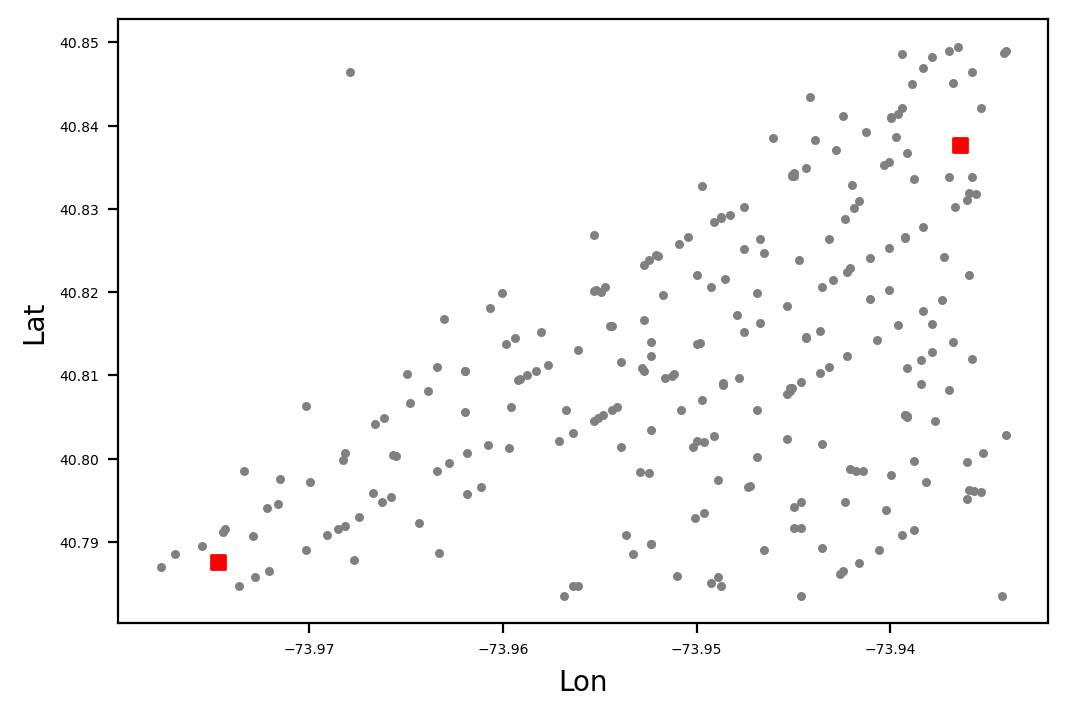

In [186]:
fig, ax = plt.subplots()
nx.draw_networkx_nodes(range(n),loc_all,ax=ax,node_size=5,node_color='gray')
nx.draw_networkx_nodes([150,251],loc_all,ax=ax,node_size=25,node_shape='s',node_color='r')
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.show()

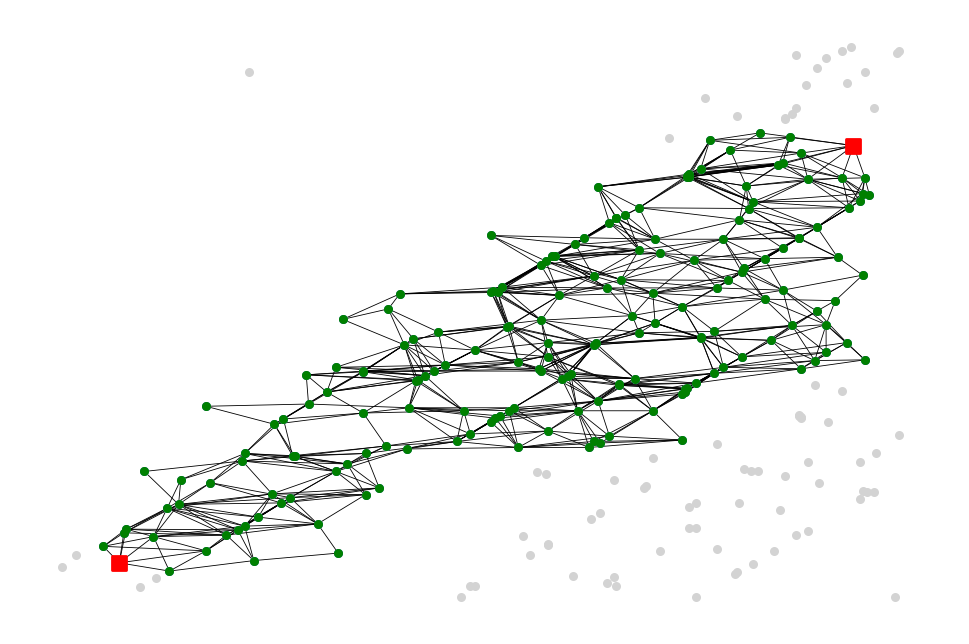

In [203]:
fig, ax = plt.subplots()
nx.draw_networkx_nodes(range(n),loc_all,ax=ax,node_size=5,node_color='lightgray')
nx.draw(G,loc_all,ax=ax,node_size=5,arrowstyle='-',width=0.3)
nx.draw_networkx_nodes(G.nodes,loc_all,ax=ax,node_size=5,node_color='g')
nx.draw_networkx_nodes([150,251],loc_all,ax=ax,node_size=25,node_shape='s',node_color='r')
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

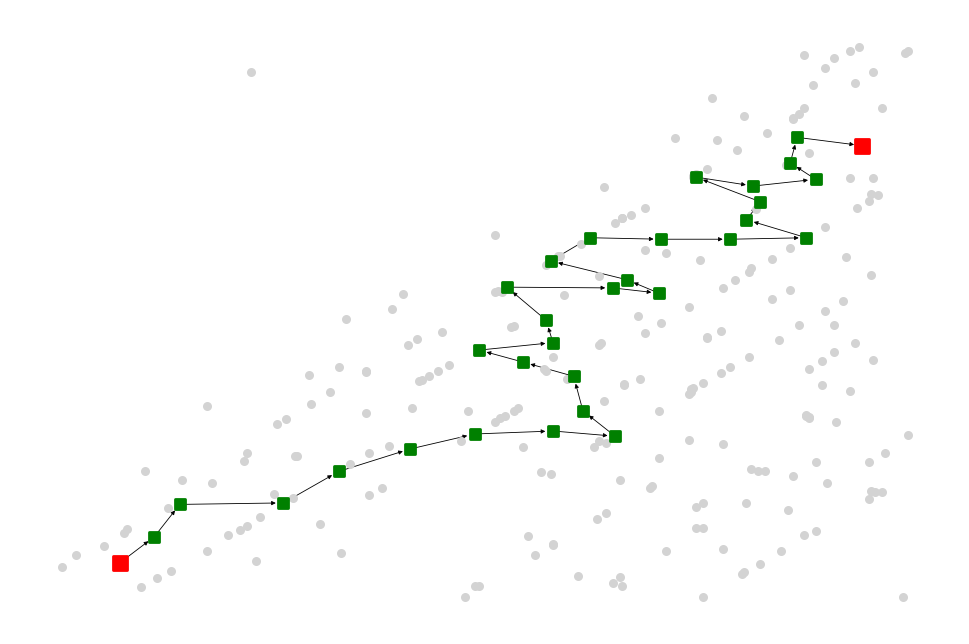

In [204]:
G_path = nx.DiGraph()
G_path.add_nodes_from(route)
for i in range(len(route)-1):
    G_path.add_edge(route[i],route[i+1])
    
fig, ax = plt.subplots()
nx.draw_networkx_nodes(range(n),loc_all,ax=ax,node_size=5,node_color='lightgray')
nx.draw(G_path,loc_all,ax=ax,node_size=15,width=0.3,arrowsize=3,node_shape='s',node_color='g')
nx.draw_networkx_nodes([150,251],loc_all,ax=ax,node_size=25,node_shape='s',node_color='r')
plt.show()

In [205]:
G_back = Bus_Route_Graph_Building_and_Pruning(251,150)
routes_back = Bean_Search_algorithm(G_back,251,150)
route_back = Bus_Route_Selection(routes_back,1)[0][0]
print(route_back)

[251, 227, 233, 188, 98, 157, 103, 61, 119, 209, 237, 204, 207, 29, 95, 144, 235, 3, 65, 146, 250, 240, 154, 88, 136, 198, 216, 197, 150]


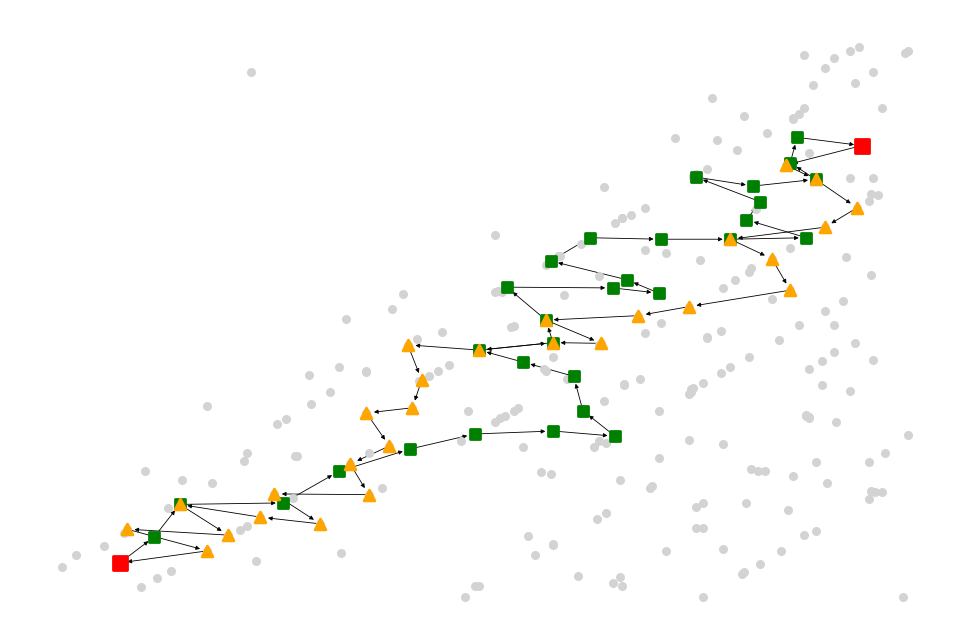

In [206]:
G_path_back = nx.DiGraph()
G_path_back.add_nodes_from(route_back)
for i in range(len(route_back)-1):
    G_path_back.add_edge(route_back[i],route_back[i+1])
fig, ax = plt.subplots()
nx.draw_networkx_nodes(range(n),loc_all,ax=ax,node_size=5,node_color='lightgray')
nx.draw(G_path,loc_all,ax=ax,node_size=15,width=0.3,arrowsize=3,node_shape='s',node_color='g')
nx.draw(G_path_back,loc_all,ax=ax,node_size=15,width=0.3,arrowsize=3,node_shape='^',node_color='orange')
nx.draw_networkx_nodes([150,251],loc_all,ax=ax,node_size=25,node_shape='s',node_color='r')
plt.show()

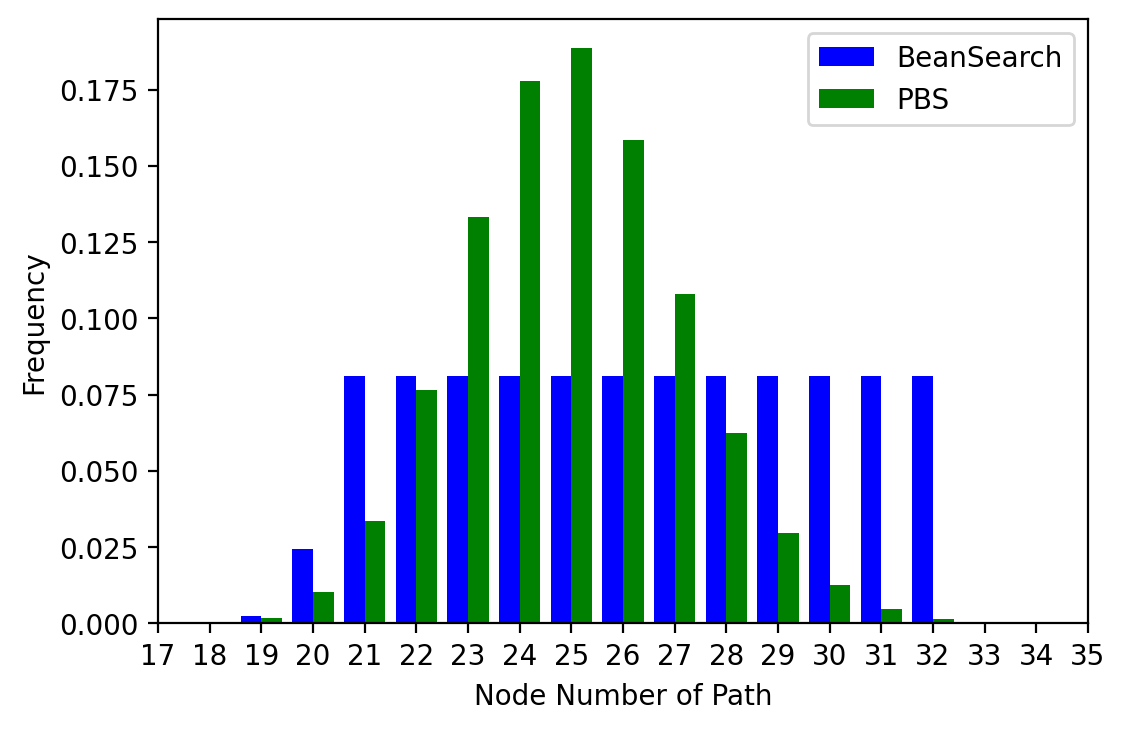

In [88]:
from matplotlib.pyplot import MultipleLocator

hist = {}
for each in routes_1:
    hist[len(each)] = hist.get(len(each),0)+1
x1 = [each-0.2 for each in range(18,37)]
y1 = [hist.get(each,0)/sum(hist.values()) for each in x]
plt.bar(x1, y1, width = 0.4, color='blue',label='BeanSearch')

hist = {}
for routes_2 in routes2:
    for each in routes_2:
        hist[len(each)] = hist.get(len(each),0)+1
x2 = [each+0.2 for each in range(18,37)]
y2 = [hist.get(each,0)/sum(hist.values()) for each in x]
plt.bar(x2, y2, width = 0.4, color='green',label='PBS')
ax=plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.xlim(17,35)
plt.xlabel('Node Number of Path')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [85]:
sum([len(each) for each in routes2])

303101

In [ ]:
sum